In [24]:
from scipy import io
import numpy as np
import pandas as pd

from classes.matlab_reader import matlab_reader
from classes.grid_funcs import map_grid,dataset,data_wizard

matlab = matlab_reader('AIRS_125KM_2018/20180212_AIRS_3DST-1_125km_grid')
# matlab = matlab_reader('AIRS_40KM_2022/20220101_AIRS_3DST-1_40km_grid.mat')

grid = map_grid(grid_size=125)
wizard = data_wizard()

# "BG" : 0,
# "k" : 1,
# "bg" : 2,
# "l" : 3,
# "m" : 4,
# "mfx" : 5,
# "mfy" : 6,



In [25]:
temp_data = matlab.select(
    hemisphere= 'nh',
    data_field='mfx',
    daytime='night',
    altitude=2)   
    
select_area_indexer = grid.select_area_indexer(
    min_lat= 55,
    max_lat= 65,
    min_lon= -180,
    max_lon= 180)

data = wizard.data_filtering(select_area_indexer = select_area_indexer ,data = temp_data)

C:\Users\joaom\AppData\Local\Temp/ipykernel_26660/1558129715.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(grid.nh_lon,


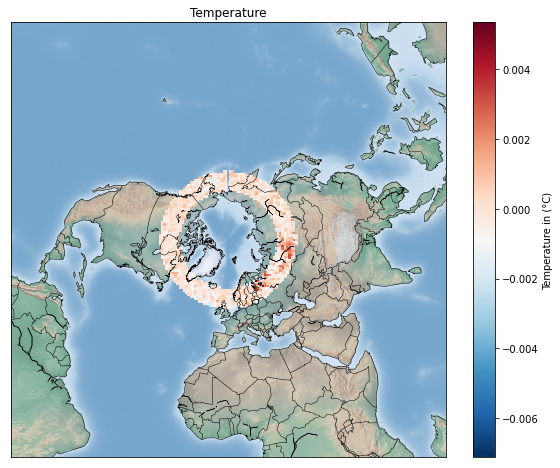

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(10, 8))

# use to plot areas in any section of the globe using a stereographic projection
# m = Basemap(projection='stere', resolution='c',
#             width=8E6, height=8E6, 
#             lat_0=55, lat_1=65,
#             lon_0=0,lon_1 = 360)

# use to plot north pole stero plot
m = Basemap(projection='npstere',boundinglat=0,lon_0=0,resolution='c')
m.shadedrelief(scale=0.5)

m.pcolormesh(grid.nh_lon, 
             grid.nh_lat, 
             data,
             latlon=True, cmap='RdBu_r',
             shading='auto')

m.drawcoastlines(linewidth=0.5,linestyle='solid')
m.drawcountries(linewidth=0.5, linestyle='solid',color='k')

plt.title('Temperature')
plt.colorbar(label='Temperature in (°C)')